In [1]:
import torch
import numpy as np
from src.datasets.uci_loader import UCIDataset
import seaborn as sns
from src.model_builder import build_model, sghmc_sampling, print_sample_performance, collect_samples, predict_y, compute_mnll, predict
from torchviz import make_dot
%load_ext autoreload
%autoreload 2

# setting PyTorch

from src.misc.settings import settings
device = settings.device
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

 # Load regression UCI dataset

data_uci = UCIDataset(dataset_path='data/uci/boston.pth', static_split=True, seed=0)
N, D = data_uci.X_train.shape
print(f'X-train: {N, D}')

/home/adm_kconstantin/miniconda3/envs/bsgp_env/lib/python3.8/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
INFO:root:Loading dataset from data/uci/boston.pth


X-train: (405, 13)


How the model works in BGSP:
1. There is a `run_regression.py` file to setup the model classes such as `RegressionModel` and the cmd line arguments
2. The `RegressionModel` in `models.py` builds the `DGP` model and launches a training loop with the hmc sampling inside
3. The `DGP` class is defined throug different `Layers` and instantiates the TensorFlow session and does the initialization 

In [6]:
#  Instantiate a model
class ARGS():
    num_inducing = 100
    n_layers = 1
    minibatch_size = 100
    window_size = 64
    output_dim= 1
    adam_lr = 0.01
    prior_inducing_type = "uniform"
    full_cov = False
    epsilon = 0.01
    mdecay = 0.05
    iterations = 4096
    num_posterior_samples = 256
    posterior_sample_spacing = 32
args = ARGS()

bsgp_model = build_model(data_uci.X_train, data_uci.Y_train, args)
#make_dot(nll, params={'nll': nll}).render("computation_graph", format="png", cleanup=True)

In [7]:
bsgp_model.reset(data_uci.X_train, data_uci.Y_train)
global_step = 0
bsgp_model.zero_grad()
for _ in range(args.iterations):
    global_step += 1
    sample = sghmc_sampling(bsgp_model)
    """
    if args.prior_type == "determinantal":
        bsgp_model.reset_Lm()
        #model.train_hypers() if hasattr(self.model, 'hyper_train_op') else None
    """
    if _ % 50 == 1:
        marginal_ll = print_sample_performance(bsgp_model)
        print('TRAIN | iter = %6d      sample marginal LL = %5.2f' % (_, marginal_ll))
    
collect_samples(bsgp_model, args.num_posterior_samples, args.posterior_sample_spacing)

ms, vs = predict(bsgp_model, data_uci.X_test, args.num_posterior_samples)
mnll = compute_mnll(ms, vs, data_uci.Y_test, num_posterior_samples=args.num_posterior_samples, ystd=data_uci.Y_train_std).mean().tolist()
print(f'Test MNLL = {mnll}')

TRAIN | iter =      1      sample marginal LL = -1.65
TRAIN | iter =     51      sample marginal LL = -1.74
TRAIN | iter =    101      sample marginal LL = -1.66
TRAIN | iter =    151      sample marginal LL = -1.75
TRAIN | iter =    201      sample marginal LL = -1.67
TRAIN | iter =    251      sample marginal LL = -1.62
TRAIN | iter =    301      sample marginal LL = -1.68
TRAIN | iter =    351      sample marginal LL = -1.58
TRAIN | iter =    401      sample marginal LL = -1.59
TRAIN | iter =    451      sample marginal LL = -1.62
TRAIN | iter =    501      sample marginal LL = -1.53
TRAIN | iter =    551      sample marginal LL = -1.55
TRAIN | iter =    601      sample marginal LL = -1.70
TRAIN | iter =    651      sample marginal LL = -1.67
TRAIN | iter =    701      sample marginal LL = -1.57
TRAIN | iter =    751      sample marginal LL = -1.77
TRAIN | iter =    801      sample marginal LL = -1.67
TRAIN | iter =    851      sample marginal LL = -1.73
TRAIN | iter =    901      s

/home/adm_kconstantin/Desktop/BSGP_Project/BSGPtorch/src/core/bsgp.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for param, value in zip(self.variables, sample.values()):


<Axes: >

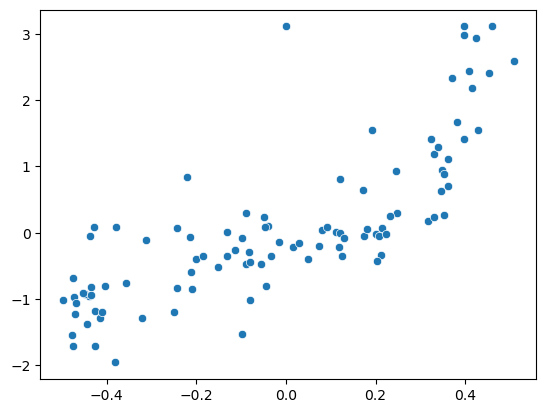

In [8]:
m = np.average(ms, 0)
v = np.average(vs + ms**2, 0) - m**2
sns.scatterplot(x=m.reshape(-1), y=data_uci.Y_test.reshape(-1))

In [5]:
ms, vs = predict(bsgp_model, data_uci.X_test, args.num_posterior_samples)
mnll = compute_mnll(ms, vs, data_uci.Y_test, num_posterior_samples=args.num_posterior_samples, ystd=data_uci.Y_train_std).mean().tolist()
print(f'Test MNLL = {mnll}')

Test MNLL = -3.514273795408619


/home/adm_kconstantin/Desktop/BSGP_Project/BSGPtorch/src/core/bsgp.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param.data.copy_(torch.tensor(value, dtype=torch.float64))
